In [1]:
import os
import sys

# Thêm thư mục cha vào sys.path
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
sys.path.insert(0, project_dir)

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from models.random_forest import train_random_forest
from models.logistic_regression import train_logistic_regression
from models.deep_learning import train_deep_learning
from utils.data_processing import clean_data, feature_engineering

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("CVD Model Training") \
    .getOrCreate()

In [2]:
# Đọc dữ liệu
data_path = os.path.join(project_dir, "data_raw", "CVD_cleaned.csv")
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Làm sạch dữ liệu
cleaned_df = clean_data(df)

# Feature Engineering
featured_df = feature_engineering(cleaned_df)

In [3]:
# Tiền xử lý dữ liệu cho ML
categorical_cols = [
    'General_Health', 'Checkup', 'Sex', 'Age_Category', 'Smoking_History',
    'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis'
]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx").fit(featured_df) for col in categorical_cols]

# Tạo feature vector
feature_cols = [
    'General_Health_idx', 'Checkup_idx', 'Exercise_idx', 'Skin_Cancer_idx', 'Other_Cancer_idx',
    'Depression_idx', 'Diabetes_idx', 'Arthritis_idx', 'Sex_idx', 'Age_Category_idx',
    'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History_idx', 'Alcohol_Consumption',
    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
label_indexer = StringIndexer(inputCol="Heart_Disease", outputCol="label").fit(featured_df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Tạo pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler])

# Fit pipeline trên dữ liệu
pipeline_model = pipeline.fit(featured_df)

# Transform dữ liệu
df_prepared = pipeline_model.transform(featured_df)

# Chia tập train/test
train, test = df_prepared.randomSplit([0.8, 0.2], seed=42)

Random Forest Results:
AUC: 0.7856
Accuracy: 0.9169


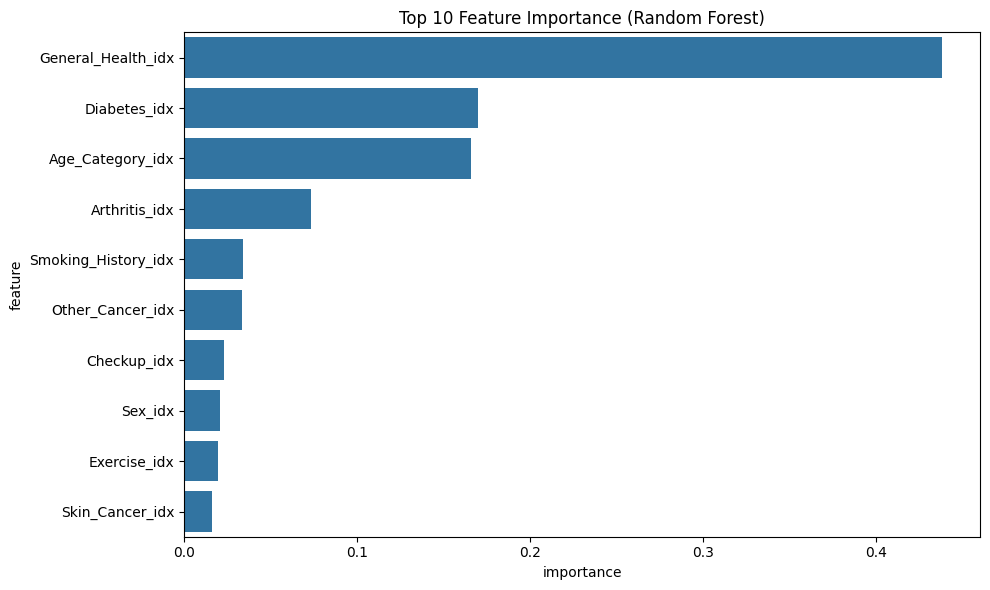

In [4]:
# Train Random Forest model
rf_model, rf_pred, rf_metrics, rf_importances = train_random_forest(train, test)

print("Random Forest Results:")
print(f"AUC: {rf_metrics['auc']:.4f}")
print(f"Accuracy: {rf_metrics['accuracy']:.4f}")

# Visualize feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [5]:
# Train Logistic Regression
lr_model, lr_pred, lr_metrics = train_logistic_regression(train, test)

print("\nLogistic Regression Results:")
print(f"AUC: {lr_metrics['auc']:.4f}")
print(f"Accuracy: {lr_metrics['accuracy']:.4f}")


Logistic Regression Results:
AUC: 0.7843
Accuracy: 0.9170


c:\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9104 - loss: 0.3916 - val_accuracy: 0.9207 - val_loss: 0.2618
Epoch 2/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9167 - loss: 0.2508 - val_accuracy: 0.9195 - val_loss: 0.2434
Epoch 3/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9185 - loss: 0.2426 - val_accuracy: 0.9205 - val_loss: 0.2381
Epoch 4/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9190 - loss: 0.2408 - val_accuracy: 0.9205 - val_loss: 0.2386
Epoch 5/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9180 - loss: 0.2405 - val_accuracy: 0.9206 - val_loss: 0.2403
Epoch 6/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9183 - loss: 0.2399 - val_accuracy: 0.9207 - val_loss: 0.2425
Epoch 7/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9192 - loss: 0.2379 - val_accuracy: 0.9207 - val_loss: 0.2368
Epoch 8/10
6937/6937 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9182 - loss: 0

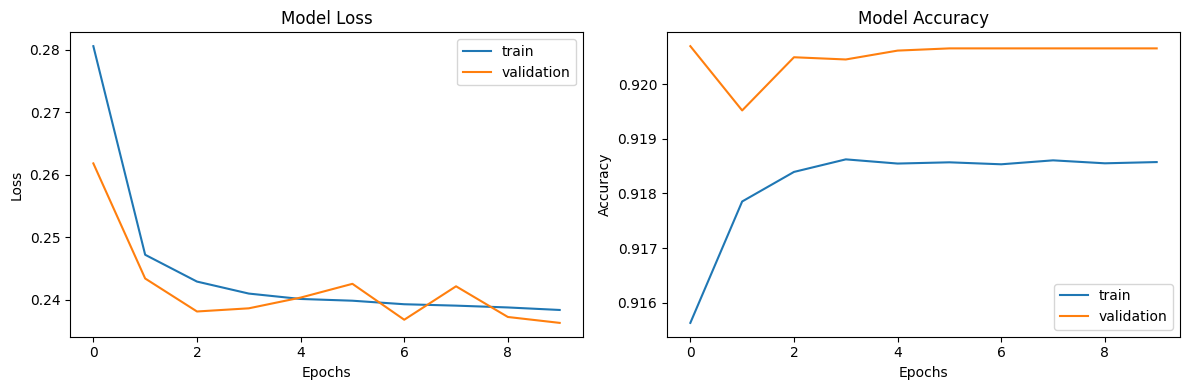

In [6]:
# Prepare data for Deep Learning
pandas_df = df_prepared.select(feature_cols + ["label"]).toPandas()
X = pandas_df[feature_cols].values
y = pandas_df["label"].values

# Train Deep Learning model
dl_model, dl_history, dl_metrics, dl_test_data = train_deep_learning(X, y)

print("\nDeep Learning Results:")
print(f"Loss: {dl_metrics['loss']:.4f}")
print(f"Accuracy: {dl_metrics['accuracy']:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dl_history.history['loss'], label='train')
plt.plot(dl_history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dl_history.history['accuracy'], label='train')
plt.plot(dl_history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

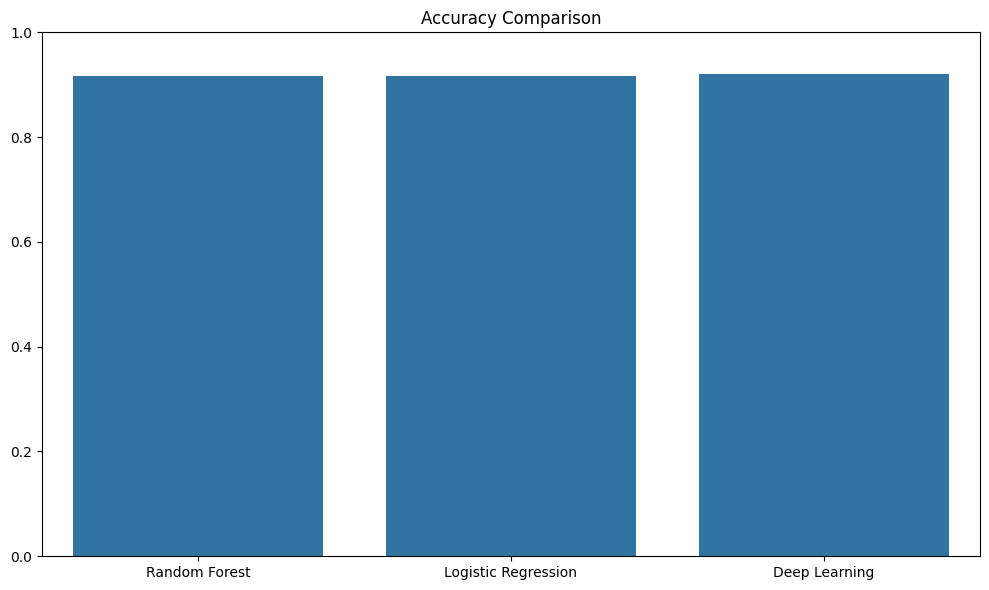

Prediction results saved to: c:\Users\racco\Documents\IE212\DOAN\CVD_Prediction_System\data_result\predictions.csv


In [7]:
# Compare all models
models = ['Random Forest', 'Logistic Regression', 'Deep Learning']
accuracies = [rf_metrics['accuracy'], lr_metrics['accuracy'], dl_metrics['accuracy']]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Đảm bảo thư mục tồn tại
os.makedirs(os.path.join(project_dir, "data_result"), exist_ok=True)

# Chuyển kết quả dự đoán sang pandas DataFrame và lưu
predictions_df = rf_pred.select(
    "General_Health", "Checkup", "Sex", "Age_Category", "BMI", 
    "Smoking_History", "Alcohol_Consumption", "Heart_Disease", 
    "Fruit_Consumption", "Green_Vegetables_Consumption", 
    "Exercise", "prediction"
).toPandas()

# Đổi tên cột để rõ ràng hơn
predictions_df = predictions_df.rename(columns={"prediction": "Predicted_Heart_Disease"})

# Lưu kết quả
predictions_path = os.path.join(project_dir, "data_result", "predictions.csv")
predictions_df.to_csv(predictions_path, index=False)

print(f"Prediction results saved to: {predictions_path}")